# STRUMPACK vs EIGEN performance

The goal of this notebook is to allow the documentation of STRUMPACK vs EIGEN performance to be maintained in a single accessible location. The environment within which this notebook is run follows the standard cctbx conda build instructions available [here](https://github.com/ExaFEL/exafel_project/tree/master/nks). For this instance, we are using the STRUMPACK-enabled build of cctbx located at [ExaFEL:cctbx_project(str_merge)](https://github.com/ExaFEL/cctbx_project/tree/str_merge). STRUMPACK is currently built using the installation script [STRUMPACK_installer_shared.sh](https://raw.githubusercontent.com/ExaFEL/exafel_project/master/strumpack/STRUMPACK_installer_shared.sh), and if the installation takes place within the same directory as moddules and build, the cctbx build process can make use of it as a backend. After the STRUMPACK solver finishes, enter the build directory, run `libtbx.refresh` and `make`. The STRUMPACK-supported modules should now build and link with the new backend.

The solution of the below systems assume that we have some **A** and *b* data already, and we can provide these in CSV file format to the solver (A is in "`row col value`" format). We can begin by importing all of the required modules. We make use of Numpy's ability to parse CSV files into numeric format, and SciPy's sparse storage format to format the matrices into the required CSR sparse storage format for solving.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        #'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (16,10)
matplotlib.rcParams['figure.dpi']= 150
import matplotlib.gridspec as gridspec

In [8]:
from __future__ import division
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler
import sys
import numpy as np
import scipy.sparse as sps

%env BOOST_ADAPTBX_FPE_DEFAULT=1
%env BOOST_ADAPTBX_SIGNALS_DEFAULT=1

env: BOOST_ADAPTBX_FPE_DEFAULT=1
env: BOOST_ADAPTBX_SIGNALS_DEFAULT=1


We load the A and b data set for solving from the locations specified below. Ideally, we can loop over and load all different data sets and process each individually. For a working example, we begin by processing a single data set, comparing Eigen and Strumpack for varying levels of shared parallelism.

In [3]:
A_path="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/A_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv"
A_mat = np.loadtxt(A_path,dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})

b_path="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/b_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv"
b_vec = np.loadtxt(b_path)

We are solving system of normal equations, and so we can safely assume that we have a square matrix. This ensures the number of rows and colums will be identical, which can be read from the length of the numpy array `b_vec`.

In [4]:
n_rows = len(b_vec)
n_cols = n_rows

We next wish to create a SciPy CSR sparse matrix type using the data from `A_mat`.

In [5]:
A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols'])))

With this, we can now create the appropriate flex data types for solving the linear system. While the operations performed upto and including this point involve many copy steps, it can be stated that the time to solve the system is much greater than the time to perform internal copies, and so we can ignore the times required for these steps for any realistic datasets.

For the solvers we require the row index pointers, the column indices, and sparse matrix values. However, it is import to first ensure that our A matrix is symmetric, and not the upper or lower triangle only. While Eigen's Cholesky deocmposition can use the upper or lower triangle, other algorithms and solvers tend to expect a full matrix. We can create this as follows.

In [6]:
tu=sps.triu(A_sp)
tl=sps.tril(A_sp)
sd=sps.diags(A_sp.diagonal())

In [7]:
if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_sp = A_sp + A_sp.transpose() - sd

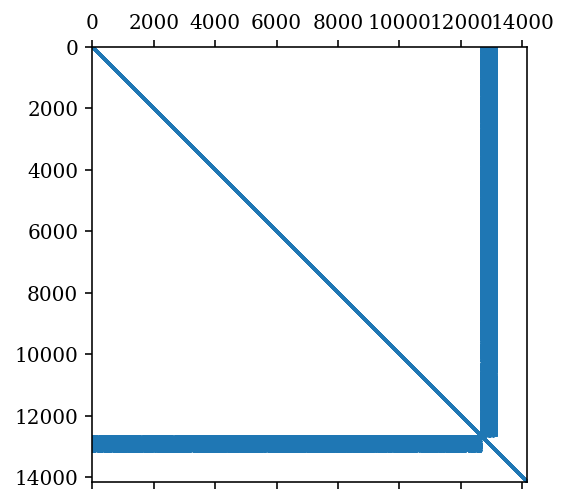

In [8]:
plt.spy(A_sp, marker='.',markersize=1.0)
plt.show()

The resulting data sets can be read directly and converted to flex types as follows.

In [9]:
A_indptr = flex.int(A_sp.indptr)
A_indices = flex.int(A_sp.indices)
A_values = flex.double(A_sp.data)
b = flex.double(b_vec)

With the data in the required format, we can now create a solver object and solve the system. We also include a built-in profiler object to time this solver step for both the STRUMPACK and EIGEN backends. 

Next, we load the OpenMP-enabled STRUMPACK solver module and the Eigen based solver. These are contained within "modules/cctbx_project/scitbx/examples/bevington/strumpack_solver_ext.cpp" and where a Boost.Python wrapper for both an EIGEN and STRUMPACK `Ax=b` solver object is provided. 

A non-notebook script exists to test this functionality at "modules/cctbx_project/scitbx/examples/bevington/strumpack_eigen_solver.py", which can be called as: 
```bash 
OMP_NUM_THREADS=x libtbx.python strumpack_eigen_solver.py A_mat.csv b_vec.csv
```
where `A_mat.csv` and `b_vec.csv` are the CSV files with the linear system to be solved, and `x` specifies the number of OpenMP threads to spawn. Additionally, the MPI-enabled STRUMPACK backend is provided by "modules/cctbx_project/scitbx/examples/bevington/strumpack_solver_ext_mpi_dist.cpp", with the Python script to test the result located at "modules/cctbx_project/scitbx/examples/bevington/strumpack_eigen_solver_mpi_dist.py". This is called as

```bash 
OMP_NUM_THREADS=x mpirun -n y libtbx.python strumpack_eigen_solver.py A_mat.csv b_vec.csv
```

As an example, the previously loaded can be provided to the solvers as follows:

In [10]:
import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")

es   = ext_omp.eigen_solver
ss   = ext_omp.strumpack_solver
ssmd = ext_mpi.strumpack_mpi_dist_solver

def run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b):
    P = Profiler("STRUMPACK_SCOTCH")
    res_strum_sc = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.auto)
    del P
    P = Profiler("STRUMPACK_METIS")
    res_strum_me = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.auto)
    del P
    
    P = Profiler("EIGEN_LDLT")
    res_eig_ldlt = es(1, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    P = Profiler("EIGEN_BICGSTAB")
    res_eig_bicgstab = es(2, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    return res_strum_sc, res_strum_me, res_eig_ldlt, res_eig_bicgstab
    
r_s_sc, r_s_me, r_e_ldlt, r_e_bicgstab = run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b)
for i in xrange(len(r_s_sc.x)):
    assert( approx_equal(r_s_sc.x[i], r_s_me.x[i]) )
    assert( approx_equal(r_s_sc.x[i], r_e_ldlt.x[i]) )
    assert( approx_equal(r_s_sc.x[i], r_e_bicgstab.x[i]) )

/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.
  try: mod = __import__(name)
/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.
  try: mod = __import__(name)


individual call time for STRUMPACK_SCOTCH: CPU,   21.410s; elapsed,    0.475s
individual call time for STRUMPACK_METIS: CPU,  146.220s; elapsed,    2.334s
individual call time for EIGEN_LDLT: CPU,    4.400s; elapsed,    0.069s
individual call time for EIGEN_BICGSTAB: CPU,    1.840s; elapsed,    0.030s


While we can use the above method to process the data, we must respecify the OMP_NUM_THREADS variable to observe different levels of scalability. %env OMP_NUM_THREADS is sufficient to test this for the first run, however for an undetermined reason the notebook must be started to allow the value to be changed. There, we can run the above tasks from a `!<command>` cell, specifying the thread count here instead.

In [11]:
OMP_SOLVER='''
from __future__ import division
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler
import sys
import numpy as np
import scipy.sparse as sps
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16,10)

A_path=sys.argv[1]
A_mat = np.loadtxt(A_path,dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})

b_path=sys.argv[2] 
b_vec = np.loadtxt(b_path)

n_rows = len(b_vec)
n_cols = n_rows

A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols'])))

#Check for triangular matrix. If so, A_sp := A+A^T - diag(A)

tu=sps.triu(A_sp)
tl=sps.tril(A_sp)
sd=sps.diags(A_sp.diagonal())

A_spS = A_sp
if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_spS = A_sp + A_sp.transpose() - sd

A_indptr = flex.int(A_sp.indptr)
A_indices = flex.int(A_sp.indices)
A_values = flex.double(A_sp.data)
b = flex.double(b_vec)

#import time
#timing_dict = {"strum":0, "eigen":0}

import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")

es   = ext_omp.eigen_solver
ss   = ext_omp.strumpack_solver

def run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b, A_spS):

    P = Profiler("EIGEN_LLT_CHOL")
    res_eig_llt_chol = es(0, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    
    P = Profiler("EIGEN_LDLT_CHOL")
    res_eig_ldlt_chol = es(1, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    
    A_indptr = flex.int(A_spS.indptr)
    A_indices = flex.int(A_spS.indices)
    A_values = flex.double(A_spS.data)
    
    P = Profiler("EIGEN_BICGSTAB")
    res_eig_bicgstab = es(2, n_rows, n_cols, A_indptr, A_indices, A_values, b)
    del P
    
    P = Profiler("STRUMPACK_SCOTCH_AUTO")
    res_strum_sc_a = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.auto)
    del P
    
    P = Profiler("STRUMPACK_METIS_AUTO")
    res_strum_mt_a = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.auto)
    del P

    P = Profiler("STRUMPACK_SCOTCH_BICGSTAB")
    res_strum_sc_bi = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.bicgstab)
    del P
    
    P = Profiler("STRUMPACK_METIS_BICGSTAB")
    res_strum_mt_bi = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.bicgstab)
    del P
    
    P = Profiler("STRUMPACK_SCOTCH_PRECBICGSTAB")
    res_strum_sc_pr = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.scotch, ext_omp.prec_bicgstab)
    del P
    
    P = Profiler("STRUMPACK_METIS_PRECBICGSTAB")
    res_strum_mt_pr = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b, ext_omp.metis, ext_omp.prec_bicgstab)
    del P
    
    for i in xrange(len(res_strum_sc.x)):
        assert( approx_equal(res_eig_llt_chol.x[i], res_eig_ldlt_chol.x[i]) )
        assert( approx_equal(res_strum_sc_a.x[i],     res_eig_bicgstab.x[i])  )
        assert( approx_equal(res_strum_sc_a.x[i],     res_eig_ldlt_chol.x[i]) )
        assert( approx_equal(res_strum_mt_a.x[i],     res_strum_sc_a.x[i])      )
        assert( approx_equal(res_strum_mt_a.x[i],     res_strum_sc_bi.x[i])      )
        assert( approx_equal(res_strum_mt_a.x[i],     res_strum_mt_bi.x[i])      )
        assert( approx_equal(res_strum_mt_a.x[i],     res_strum_sc_pr.x[i])      )
        assert( approx_equal(res_strum_mt_a.x[i],     res_strum_mt_pr.x[i])      )

run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b, A_spS)
'''

In [12]:
OMP_SOLVER = OMP_SOLVER
OMP_SOLVER_FILE = open("OMP_SOLVER.py", "w")
OMP_SOLVER_FILE.write(OMP_SOLVER)
OMP_SOLVER_FILE.close()

DATAPATH="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/"
A_LIST = !find {DATAPATH} -iname "A*.csv"
B_LIST = [ii.replace('/A_','/b_') for ii in A_LIST]

We now record the indices of the data with a specific number of images. We can use these indices to later submit jobs with a given number of frames, and hence resulting matrix size.

In [13]:
list_idx={}
for imgs in ['1k','5k','10k','32k']:
    list_idx.update({imgs:[i for i, j in enumerate(A_LIST) if imgs in j]})
list_idx

{'10k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 '1k': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 '32k': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
 '5k': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}

With the file writtent to disk, we now create a loop in mixed Python/Bash to call the solver, then extract the standard output from the profiler to examine the OpenMP scalability of STRUMPACK. The profiler code wraps each solver, and does not take into account the load-times for the data.

In [14]:
str_out={}
import os
threads_list = [16]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "1k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        
        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        print {A_path}, {b_path}
        
        for threads in threads_list:
            print "OMP_NUM_THREADS:=%d"%threads

            val = !OMP_NUM_THREADS={threads} libtbx.python ./OMP_SOLVER.py {A_path} {b_path}
            print val
            for s in val:
                if "assert" in s:
                    raise Exception("Solutions not equal! Halting")
            key = 'omp' + str(threads) + '_' + dat_name
            str_out.update({key:val})

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Rxy-
set(['/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/A_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv']) set(['/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/b_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv'])
OMP_NUM_THREADS:=16
['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import_

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    0.240s; elapsed,    0.237s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    0.230s; elapsed,    0.232s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.240s; elapsed,    0.024s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    1.990s; elapsed,    1.995s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    2.110s; elapsed,    2.120s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.520s; elapsed,    0.048s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    0.830s; elapsed,    0.819s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    0.860s; elapsed,    0.858s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.300s; elapsed,    0.030s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    0.220s; elapsed,    0.231s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    0.240s; elapsed,    0.236s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.530s; elapsed,    0.046s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    3.880s; elapsed,    3.883s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    4.090s; elapsed,    4.098s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.550s; elapsed,    0.050s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    1.990s; elapsed,    1.994s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    2.120s; elapsed,    2.119s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.240s; elapsed,    0.024s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', 'individual call time for EIGEN_LLT_CHOL: CPU,    3.890s; elapsed,    3.903s', 'individual call time for EIGEN_LDLT_CHOL: CPU,    4.070s; elapsed,    4.073s', 'individual call time for EIGEN_BICGSTAB: CPU,    0.520s; elapsed,    0.047s', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '#

In the event of a crash, it is wise to save the resulting data (JSON and Pickle) to disk...

In [15]:
import json, cPickle
with open("OMP_SOLVER_TIME_1k_all.json", "w") as OMP_SOLVER_TIME_FILE:
    OMP_SOLVER_TIME_FILE.write(json.dumps(str_out)) 
with open("OMP_SOLVER_TIME_1k_all.pickle", "w") as OMP_SOLVER_TIME_FILE:
    OMP_SOLVER_TIME_FILE.write(cPickle.dumps(str_out))

...which can then be easily reloaded later. Now, we parse the string, extract the timing data, and add it to the python object at the specified thread number index. This allows for easily sorting and plot the data later.

In [14]:
import cPickle
str_out=cPickle.load(open('OMP_SOLVER_TIME_1k_all.pickle', 'rb'))

To simplify indexing later for plots, we create shortened keys. Additionally, we ca also separate the data based upon unique index set and thread numbers.

In [15]:
str_out_sm={}
for k in str_out.keys():
    str_out_sm.update({k.replace('levmar.parameter_flags=','').replace('_strum_1k_omp1_params','_'):str_out[k]})

In [16]:
import pandas as pd
u_dat={}
threads_list=[16]
uniq_ref = set([k.split('_')[1] for k in str_out_sm.keys()])
df_list=[]
for u in uniq_ref:
    same_t = lambda: None #Functions are objects, so legit
    same_t.strum_scotch_a = []
    same_t.strum_metis_a = []
    same_t.strum_scotch_bi = []
    same_t.strum_metis_bi = []
    same_t.strum_scotch_pr = []
    same_t.strum_metis_pr = []
    same_t.eig_llt = []
    same_t.eig_ldlt = []
    same_t.eig_bicgstab = []
    for t in threads_list:
        same_t.strum_metis_a.append(str_out_sm["omp%d_%s"%(t,u)][-2].rsplit(',')[-2].strip()[0:-1])
        same_t.eig_ldlt.append(str_out_sm["omp%d_%s"%(t,u)][-3].rsplit(',')[-2].strip()[0:-1])
        same_t.strum_metis_bi.append(str_out_sm["omp%d_%s"%(t,u)][-4].rsplit(',')[-2].strip()[0:-1])
        same_t.strum_scotch_pr.append(str_out_sm["omp%d_%s"%(t,u)][-5].rsplit(',')[-2].strip()[0:-1])
        same_t.strum_scotch_a.append(str_out_sm["omp%d_%s"%(t,u)][-6].rsplit(',')[-2].strip()[0:-1])
        same_t.eig_bicgstab.append(str_out_sm["omp%d_%s"%(t,u)][-7].rsplit(',')[-2].strip()[0:-1]) 
        same_t.strum_scotch_bi.append(str_out_sm["omp%d_%s"%(t,u)][-8].rsplit(',')[-2].strip()[0:-1])
        same_t.eig_llt.append(str_out_sm["omp%d_%s"%(t,u)][-9].rsplit(',')[-2].strip()[0:-1])
        same_t.strum_metis_pr.append(str_out_sm["omp%d_%s"%(t,u)][-10].rsplit(',')[-2].strip()[0:-1])

    u_dat.update({u:same_t})
    str_E_LLT = "EIG_LLT_%s"%u
    str_E_LDLT = "EIG_LDLT_%s"%u
    str_E_BICGSTAB = "EIG_BICGSTAB_%s"%u
    str_S_SCOTCH_A = "STRUM_SCOTCHA_%s"%u
    str_S_METIS_A = "STRUM_METISA_%s"%u
    str_S_SCOTCH_BI = "STRUM_SCOTCHBI_%s"%u
    str_S_METIS_BI = "STRUM_METISBI_%s"%u
    str_S_SCOTCH_PR = "STRUM_SCOTCHPR_%s"%u
    str_S_METIS_PR = "STRUM_METISPR_%s"%u
    df_list.append( pd.DataFrame({str_E_LLT:same_t.eig_llt, str_E_LDLT:same_t.eig_ldlt, str_E_BICGSTAB:same_t.eig_bicgstab, str_S_SCOTCH_A:same_t.strum_scotch_a, str_S_METIS_A:same_t.strum_metis_a, str_S_SCOTCH_BI:same_t.strum_scotch_bi, str_S_METIS_BI:same_t.strum_metis_bi, str_S_SCOTCH_PR:same_t.strum_scotch_pr, str_S_METIS_PR:same_t.strum_metis_pr }, index=threads_list).transpose() )

We now have a list of Pandas Dataframes, with which we can combine to a single entity. We can then proceed to plot the resulting columns, comparing both Eigen and STRUMPACK for each specific set of refined parameters.

In [17]:
perf_s = pd.concat(df_list).transpose()
perf_s.transpose()

,16
EIG_BICGSTAB_Rxy-Deff-Eta-,0.024
EIG_LDLT_Rxy-Deff-Eta-,2.119
EIG_LLT_Rxy-Deff-Eta-,1.994
STRUM_METISA_Rxy-Deff-Eta-,2.157
STRUM_METISBI_Rxy-Deff-Eta-,0.104
STRUM_METISPR_Rxy-Deff-Eta-,2.350
STRUM_SCOTCHA_Rxy-Deff-Eta-,0.220
STRUM_SCOTCHBI_Rxy-Deff-Eta-,0.111
STRUM_SCOTCHPR_Rxy-Deff-Eta-,0.187
EIG_BICGSTAB_Bfactor-,0.049


With the performance data in an easily accessible format, we can plot each respective data set for all solvers. Each bar corresponds to the parameters being refined, where the colour indicates the respective solver used, and the y-axis is the time to solve the system in seconds.

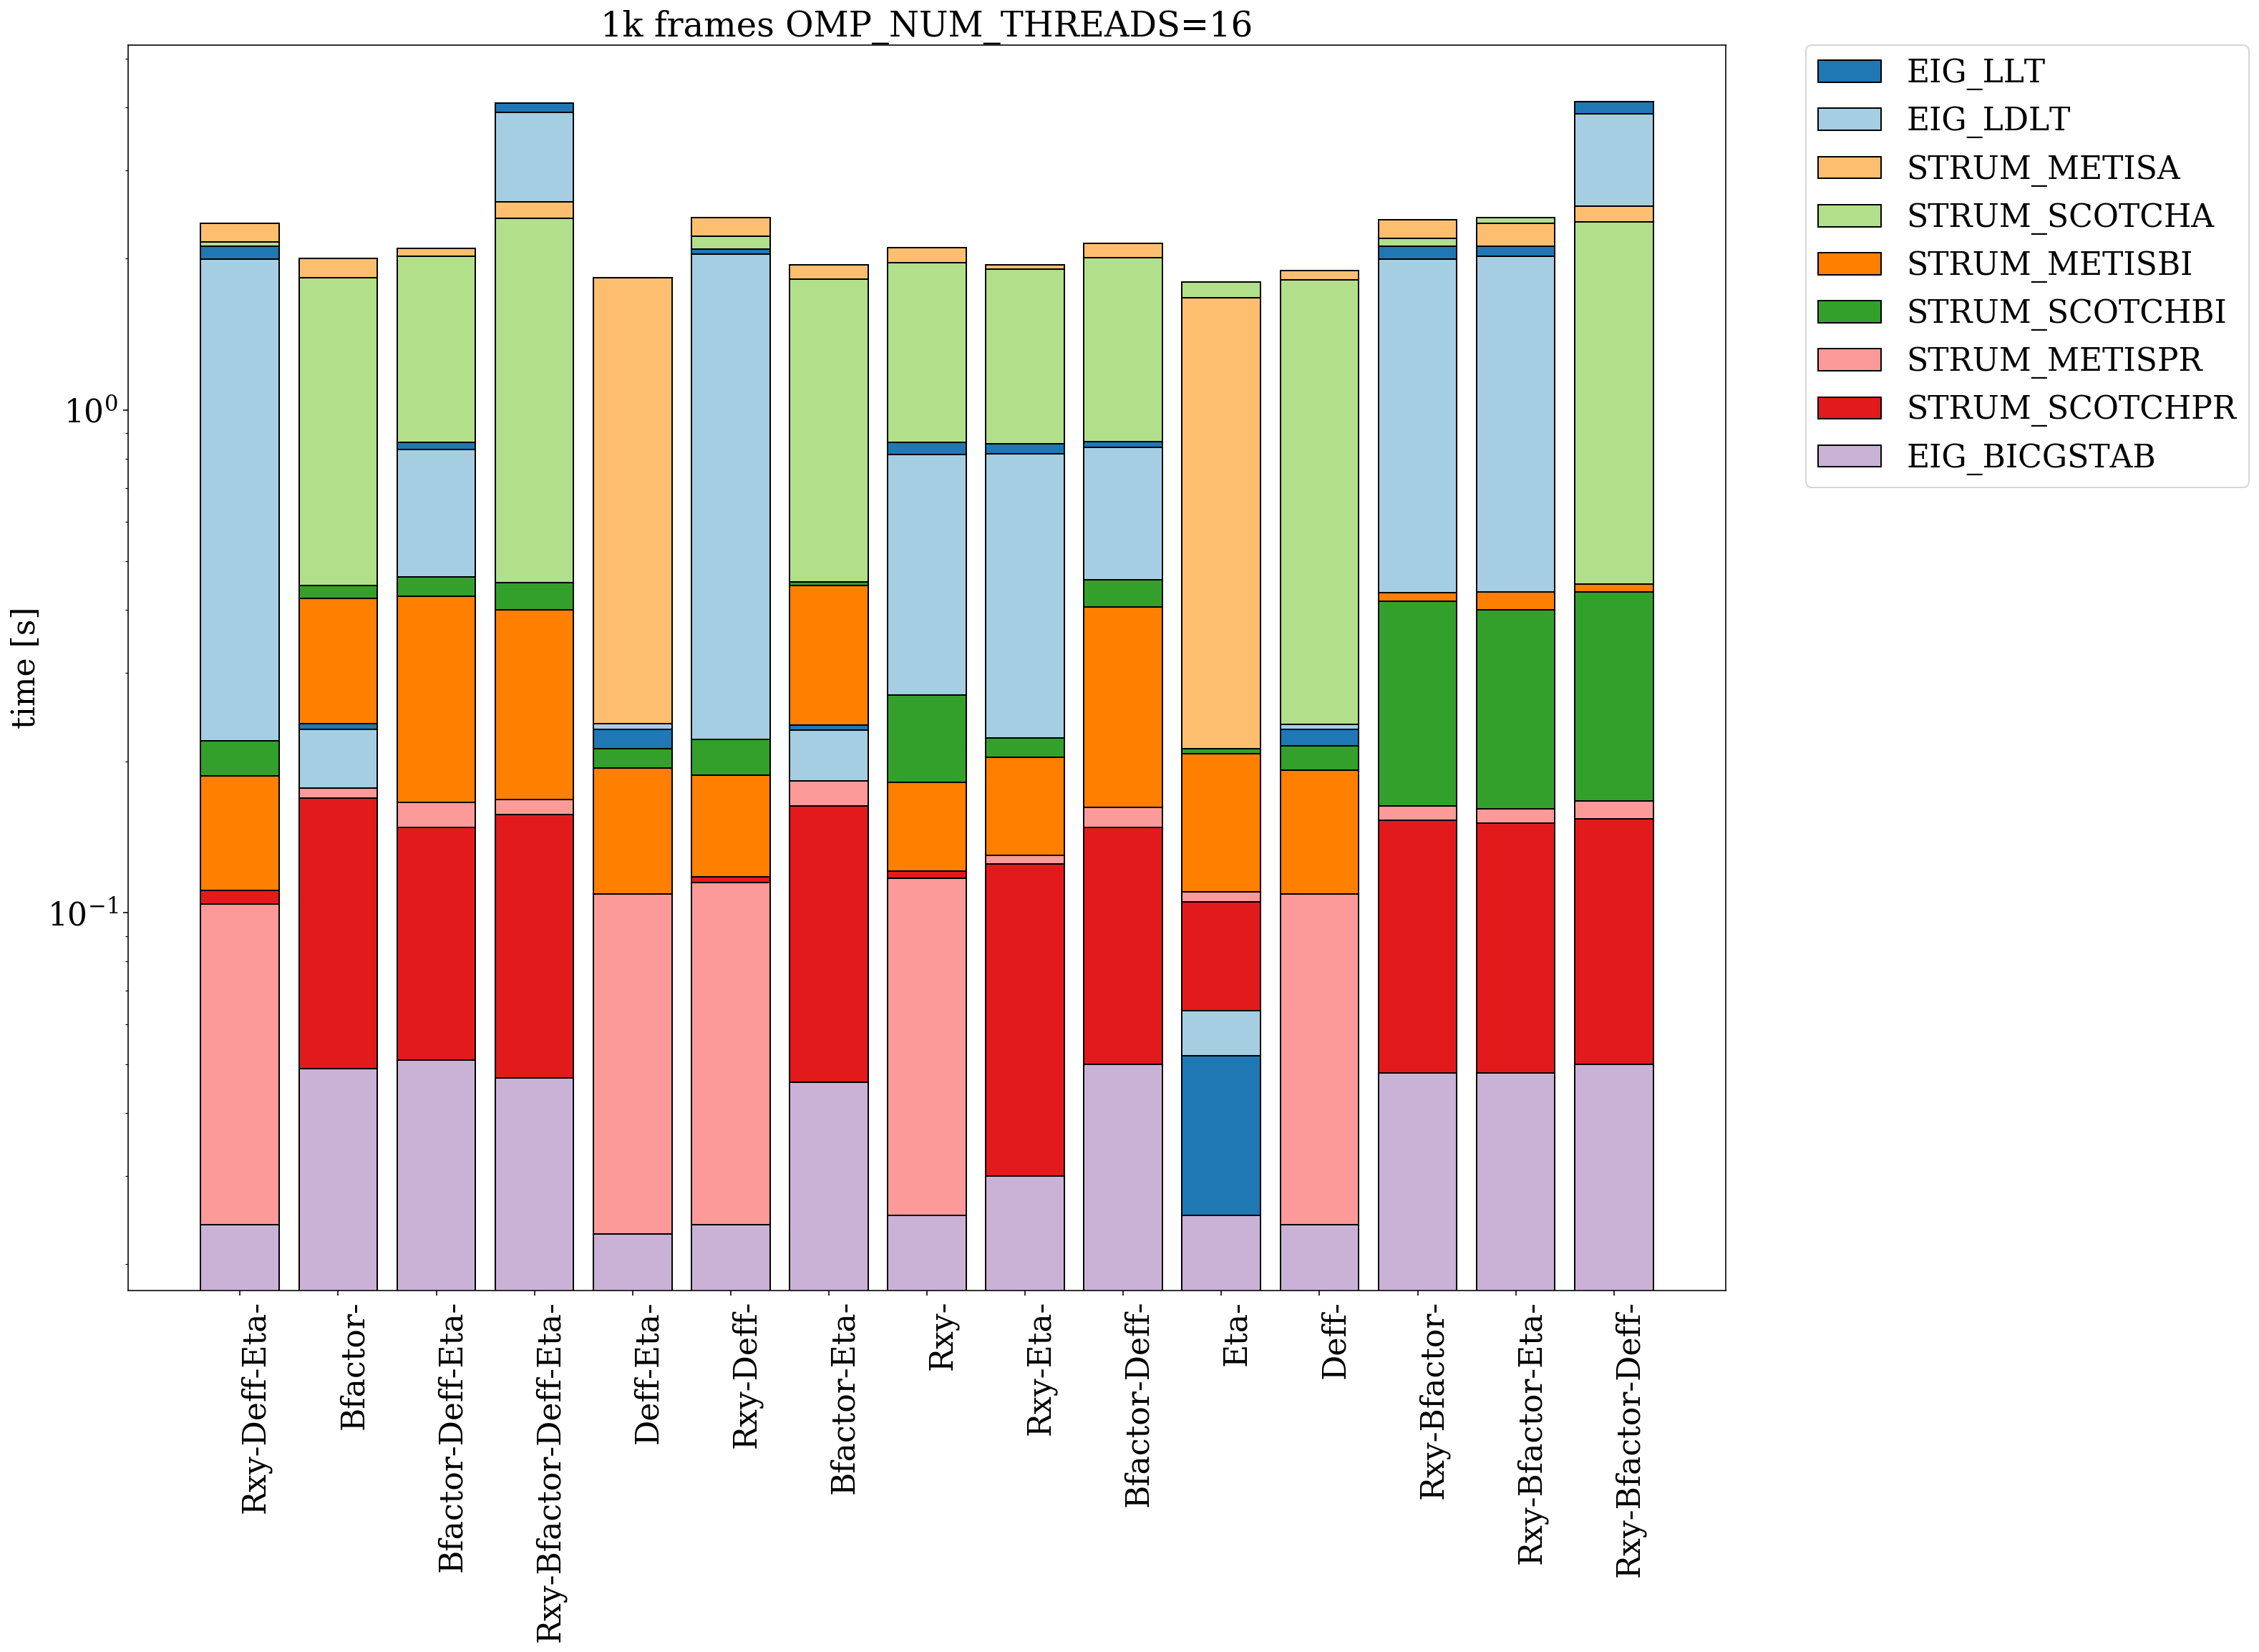

In [18]:
# define the figure size and grid layout properties
matplotlib.rcParams.update({'font.size': 22})
figsize = (20, 16)
cols = 4
fig3 = plt.figure(num=3, figsize=figsize)
ax3 = plt.axes()
ii = []
uu=[]
keys=['EIG_LLT','EIG_LDLT','STRUM_METISA','STRUM_SCOTCHA','STRUM_METISBI','STRUM_SCOTCHBI','STRUM_METISPR','STRUM_SCOTCHPR','EIG_BICGSTAB']
colours = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
key_col = {k:v for (k,v) in zip(keys,colours)}
hatch_pattern = [ '/' , '\\' , '|' , '-' , '+' , 'x' ,'o' ,'O' , '.', '*']
for i, u in enumerate(uniq_ref):
    p_list=[]
    ax3.set_ylabel('time [s]')
    keys_df = [k+'_'+u for k in keys]
    dfl=perf_s[keys_df]
    
    m = zip(dfl.as_matrix().astype(np.float)[0], dfl.keys().tolist() )
    m = sorted(m,key=lambda x: x[0])

    for p in reversed(xrange(len(m))):
        c_label =  "_".join(m[p][1].split('_')[0:2])
        p_list.append( plt.bar(i, m[p][0], label=m[p][1], color=key_col[c_label], edgecolor='k') )
    
    ii.append(i)
    uu.append(u)
ax3.set_yscale('log',basey=10)
plt.title('1k frames OMP_NUM_THREADS=16', fontsize=24)
plt.xticks(ii, uu)
plt.setp(ax3.get_xticklabels(), rotation=90, ha='left')
ax3.legend(p_list,keys,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,)

plt.savefig('omp_1kframes_allsolvers_omp16.pdf', pad_inches=10)

So far we have examined the single threaded and OpenMP enabled solver performance. Strumpack also allows us to use the distributed MPI backend. We can set this up as follows using the ipyparallel backend, or invoke an `mpirun` call using the cell bash bash environment. For completeness, the ipyparallel environment can be set up as follows:

```bash
conda install ipyparallel
jupyter serverextension enable --py ipyparallel --user
jupyter nbextension install --py ipyparallel --user 
jupyter nbextension enable --py ipyparallel --user
ipcluster start --profile=mpi -n 4
```

Take note of the controller client json file `<HOME>/.ipython/profile_<PROFILE_NAME>/security/ipcontroller-client.json`. This will be used to allow the notebook to connect to the ipyparallel cluster profile `mpi`. We can then return the handle of the cluster environment with:

In [30]:
import ipyparallel as ipp
#c = ipp.Client('/net/cci-filer2/raid1/home/mlxd/.ipython/profile_mpi/security/ipcontroller-client.json')
c = ipp.Client()
rc=c[:]
c.ids #Instance IDs

[0]

For our purposes it can be easier to call the solver using the `!` bash environment, as was used for the OpenMP studies earlier. A simple test script can be performed as follows, which tests the listed solvers against the MPI backend.

In [21]:
!OMP_NUM_THREADS=1 mpirun -np 2 libtbx.python \
/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/\
modules/cctbx_project/scitbx/examples/bevington/strumpack_eigen_solver_mpi_dist.py \
/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/\
out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/A_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv \
/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/\
out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/b_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv

/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.
  try: mod = __import__(name)
/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.
  try: mod = __import__(name)
/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.
  try: mod = __import__(name)
/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.
  try: mod = __import__(name)
14151 7075.5
# ***** WARNING ***********

We now use the same procedure of creating a solver file, write to disk, and call with the respective matrix arguments with `OMP_NUM_THREADS` and `mpirun -n`. For simplicity, we examine the OpenMP `STRUM_SCOTCHA`, `EIGEN_LDLT` and `EIGEN_BICGSTAB`, compared with the MPI-enabled `STRUM_SCOTCHA` (we may also examine the full range of algorithms as used in the previous example).

In [33]:
MPI_SOLVER='''
from __future__ import division

import mpi4py
mpi4py.rc.threads = True
mpi4py.rc.thread_level = "funneled"
from mpi4py import MPI

assert MPI.Is_initialized()
assert MPI.Query_thread() == MPI.THREAD_FUNNELED

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

from scitbx.matrix import sqr,col
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler

import boost.python
ext_omp = boost.python.import_ext("scitbx_examples_strumpack_solver_ext")
ext_mpi = boost.python.import_ext("scitbx_examples_strumpack_mpi_dist_solver_ext")
import sys
import numpy as np

import scipy.sparse as sps

if rank==0:
  A_mat = np.loadtxt(sys.argv[1],dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})
  b_vec = np.loadtxt(sys.argv[2])
  n_rows = len(b_vec)
  n_cols = n_rows
  nnz = len(A_mat['vals'])
  print n_rows, n_rows/size
  #Convert the sparse CSR to flex doubles, then use them to solve using the implemented framework
  A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols']))) 

  #Check if upper/lower triangular only, and generate full if so
  tu=sps.triu(A_sp)
  tl=sps.tril(A_sp)
  sd=sps.diags(A_sp.diagonal())

  A_spS = A_sp
  if tu.nnz == sd.getnnz() or tl.nnz == sd.getnnz():
    A_spS = A_sp + A_sp.transpose() - sd

  import numpy as np
  row_idx_split = np.array_split(np.arange(n_rows),size)
  len_row_idx_split = flex.int( np.cumsum( np.append([0], [len(i) for i in row_idx_split]) ).tolist() )
  P = Profiler("STRUMPACK_OMP")
  A_indptr = flex.int( A_spS.indptr )
  A_indices = flex.int( A_spS.indices )
  A_data = flex.double( A_spS.data )
  b = flex.double( b_vec )
  res_strum_omp = ext_omp.strumpack_solver(
                    n_rows, n_cols, 
                    A_indptr, A_indices,
                    A_data, b,
                    ext_omp.scotch, 
                    ext_omp.auto
                 )
  del P
  P = Profiler("EIGEN_LDLT")
  res_eig_ldlt = ext_omp.eigen_solver(1, n_rows, n_cols, A_indptr, A_indices, A_data, b)
  del P
  P = Profiler("EIGEN_BICGSTAB")
  res_eig_bicgstab = ext_omp.eigen_solver(2, n_rows, n_cols, A_indptr, A_indices, A_data, b)
  del P

else:
  A_spS=None
  row_idx_split=None
  len_row_idx_split=None
  b_vec=None
  n_cols=None

if size>1:
  #Broadcast data to each rank
  A_spS = comm.bcast(A_spS, root=0)
  row_idx_split = comm.bcast(row_idx_split, root=0)
  len_row_idx_split = comm.bcast(len_row_idx_split, root=0)
  b_vec = comm.bcast(b_vec, root=0)
  n_cols = comm.bcast(n_cols, root=0)

  #Take subset of data for each rank
  A_row_offset = flex.int(A_spS[row_idx_split[rank],:].indptr)
  A_col_offset = flex.int(A_spS[row_idx_split[rank],:].indices)
  A_values = flex.double(A_spS[row_idx_split[rank],:].data)
  b = flex.double(b_vec[row_idx_split[rank]])

  P = Profiler("STRUMPACK_MPI_DIST_RANK=%d"%rank)
  res_strum_mpi_local = ext_mpi.strumpack_mpi_dist_solver(len(row_idx_split[rank]), n_cols, comm, A_row_offset, A_col_offset, A_values, b, len_row_idx_split, ext_mpi.scotch, ext_mpi.auto)
  strum_result_mpi_list = comm.gather(res_strum_mpi_local.x, root=0)
  del P
  if rank==0:
    strum_result_mpi = flex.double()
    for l in strum_result_mpi_list:
      strum_result_mpi.extend(l)

#MPI.Finalize()
if rank==0:
  strum_result_omp = res_strum_omp.x
  eig_result_ldlt = res_eig_ldlt.x
  eig_result_bicgstab = res_eig_bicgstab.x

  for ii in xrange(len(strum_result_omp)):
    assert approx_equal( strum_result_omp[ii], eig_result_ldlt[ii]  )
    assert approx_equal( strum_result_omp[ii], eig_result_bicgstab[ii]  )
    if size>1:
      assert approx_equal( strum_result_omp[ii], strum_result_mpi[ii]  )
  print "Strumpack solutions agree with Eigen"

'''

In [34]:
MPI_SOLVER_FILE = open("MPI_SOLVER.py", "w")
MPI_SOLVER_FILE.write(MPI_SOLVER)
MPI_SOLVER_FILE.close()

DATAPATH="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/"
A_LIST = !find {DATAPATH} -iname "A*.csv"
B_LIST = [ii.replace('/A_','/b_') for ii in A_LIST]

We intend to examine performance while varying both OMP_NUM_THREADS and the MPI process number to determine an optimal set of parameters for the distributed backend. In the following example we test between 1 to 16 OpenMP threads per process, and from 1 to 16 MPI processes, assuming a total of threads*processes <= 32 cores. The resulting data set will be a scalar field of time as a function of both variables, which we can plot as a heatmap. We can begin by running the analysis on a 1000 image dataset.

In [ ]:
str_out={}
import os
threads_list = [1,2,4,8,16]
mpi_proc_list = [1,2,4,8,16]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "1k":
        print "Skipping %s"%imgs_size
        continue

    for imgs_idx in list_idx[imgs_size]:

        A_path = A_LIST[imgs_idx]; b_path = B_LIST[imgs_idx]
        dat_name = A_path.split('/')[-1][2:-4]

        print "Data Set Name:=%s"%(dat_name)

        #Ensure the A and b data are matched correctly
        assert(os.path.dirname(A_path) == os.path.dirname(b_path))
        print {A_path}, {b_path}

        for procs in mpi_proc_list:
            for threads in threads_list:
                if threads*procs <= 32:
                    print "mpirun -n %d"%procs
                    print "OMP_NUM_THREADS:=%d"%threads

                    val = !OMP_NUM_THREADS={threads} mpirun -n {procs} libtbx.python ./MPI_SOLVER.py {A_path} {b_path}
                    print val
                    for s in val:
                        if "assert" in s:
                            raise Exception("Solutions not equal! Halting with log: %s"%val)
                    key = 'mpi' + str(procs)  + 'omp' + str(threads) + '_' + dat_name
                    str_out.update({key:val})


Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Rxy-
set(['/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/A_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv']) set(['/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Rxy-/b_strum_1k_omp1_paramslevmar.parameter_flags=Rxy-.csv'])
mpirun -n 1
OMP_NUM_THREADS:=1
['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod 

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlx

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 13651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 13651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13151 13151.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13151 6575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13151 6575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13151 6575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 14651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlx

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 14651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 14151.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 14151.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 13651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 13651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '13651 6825.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 15151.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 7575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 7575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 7575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 14651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 14651.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14651 7325.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 14151.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '14151 7075.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/rai

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 15151.0', '# ***** WARNING ****************************************************', '# Detected a large number of levels in the frontal/elimination tree.', '# STRUMPACK currently does not handle this safely, which', '# could lead to segmentation faults due to stack overflows.', '# As a remedy, you can try to increase the stack size,', '# or try a different ordering (metis, scotch, ..).', '# When using metis, it often helps to use --sp_enable_METIS_NodeNDP,', '# (enabled by default) iso --sp_enable

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 7575.5',

['/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::KrylovSolver already registered; second conversion method ignored.', '  try: mod = __import__(name)', '/net/dials/raid1/mlxd/InDev/STRUMPACK_MPI_DIST/modules/cctbx_project/boost/python.py:25: RuntimeWarning: to-Python converter for strumpack::ReorderingStrategy already registered; second conversion method ignored.', '  try: mod = __import__(name)', '15151 7575.5',

In [16]:
import json, cPickle
with open("OMP_SOLVER_TIME_1k_MPI.json", "w") as OMP_SOLVER_TIME_FILE:
    OMP_SOLVER_TIME_FILE.write(json.dumps(str_out)) 
with open("OMP_SOLVER_TIME_1k_MPI.pickle", "w") as OMP_SOLVER_TIME_FILE:
    OMP_SOLVER_TIME_FILE.write(cPickle.dumps(str_out))

In [2]:
import cPickle
str_out=cPickle.load(open('OMP_SOLVER_TIME_1k_MPI.pickle', 'rb'))

In [3]:
str_out_sm={}
for k in str_out.keys():
    str_out_sm.update({k.replace('levmar.parameter_flags=','').replace('_strum_1k_omp1_params','_'):str_out[k]})

In [5]:
import numpy as np
u_dat = {}

threads_list = [1,2,4,8,16]
mpi_proc_list = [1,2,4,8,16]
uniq_ref = set([k.split('_')[1] for k in str_out_sm.keys()])
df_list=[]
for u in uniq_ref:
    same_t = lambda: None #Functions are objects, so legit
    same_t.strum_scotch_a = np.empty(shape=(5,5))
    same_t.strum_mpi_ptscotch = np.empty(shape=(5,5))
    same_t.eig_ldlt = np.empty(shape=(5,5))
    same_t.eig_bicgstab = np.empty(shape=(5,5))
    
    same_t.strum_scotch_a[:] = np.nan
    same_t.strum_mpi_ptscotch[:] = np.nan
    same_t.eig_ldlt[:] = np.nan
    same_t.eig_bicgstab[:] = np.nan
    
    for m_idx,m in enumerate(mpi_proc_list):
        for t_idx,t in enumerate(threads_list):
            if m*t <=32:
                t_STRUMPACK_OMP = [ s for s in str_out_sm["mpi%domp%d_%s"%(m,t,u)] if 'STRUMPACK_OMP' in s]
                t_STRUMPACK_MPI_DIST_RANK = [ s for s in str_out_sm["mpi%domp%d_%s"%(m,t,u)] if 'STRUMPACK_MPI_DIST_RANK' in s]
                t_EIGEN_LDLT = [ s for s in str_out_sm["mpi%domp%d_%s"%(m,t,u)] if 'EIGEN_LDLT' in s]
                t_EIGEN_BICGSTAB = [ s for s in str_out_sm["mpi%domp%d_%s"%(m,t,u)] if 'EIGEN_BICGSTAB' in s]
                
                if m != 1:
                    same_t.strum_mpi_ptscotch[m_idx,t_idx] = t_STRUMPACK_MPI_DIST_RANK[-1].rsplit(',')[-2].strip()[0:-1]
                same_t.strum_scotch_a[m_idx,t_idx] = t_STRUMPACK_OMP[-1].rsplit(',')[-2].strip()[0:-1]
                same_t.eig_bicgstab[m_idx,t_idx] = t_EIGEN_BICGSTAB[-1].rsplit(',')[-2].strip()[0:-1]
                same_t.eig_ldlt[m_idx,t_idx] = t_EIGEN_LDLT[-1].rsplit(',')[-2].strip()[0:-1]

    u_dat.update({u:same_t})
    str_E_LDLT = "EIG_LDLT_%s"%u
    str_E_BICGSTAB = "EIG_BICGSTAB_%s"%u
    str_S_SA = "STR_SA_%s"%u
    str_S_MPI = "STR_MPI_%s"%u
    df_dict = { str_E_LDLT:same_t.eig_ldlt, 
                str_E_BICGSTAB:same_t.eig_bicgstab,
                str_S_SA:same_t.strum_scotch_a,
                str_S_MPI:same_t.strum_mpi_ptscotch
              }
    df_dict

With the data correctly parsed, we can plot the performance of each solver with $t(\textrm{MPI}, \textrm{OMP})$. Not, that the MPI solver does not operate with a single thread, and so will not have data in this row. Subsequently, the relative performance of the OpenMP STRUMPACK backend to the MPI backend is shown. While it would be best compared for the same upp er limit of `threads*processes`, it can be sufficient to see scalability across the board to identify MPI-enabled sweet-spots. Additionally, as no MPI benefit exists for the other solvers, the launching of processes and overheads can slow performance overal. Thus, it is best to examine the single process data for the non MPI-enabled data.

# STRUMPACK MPI

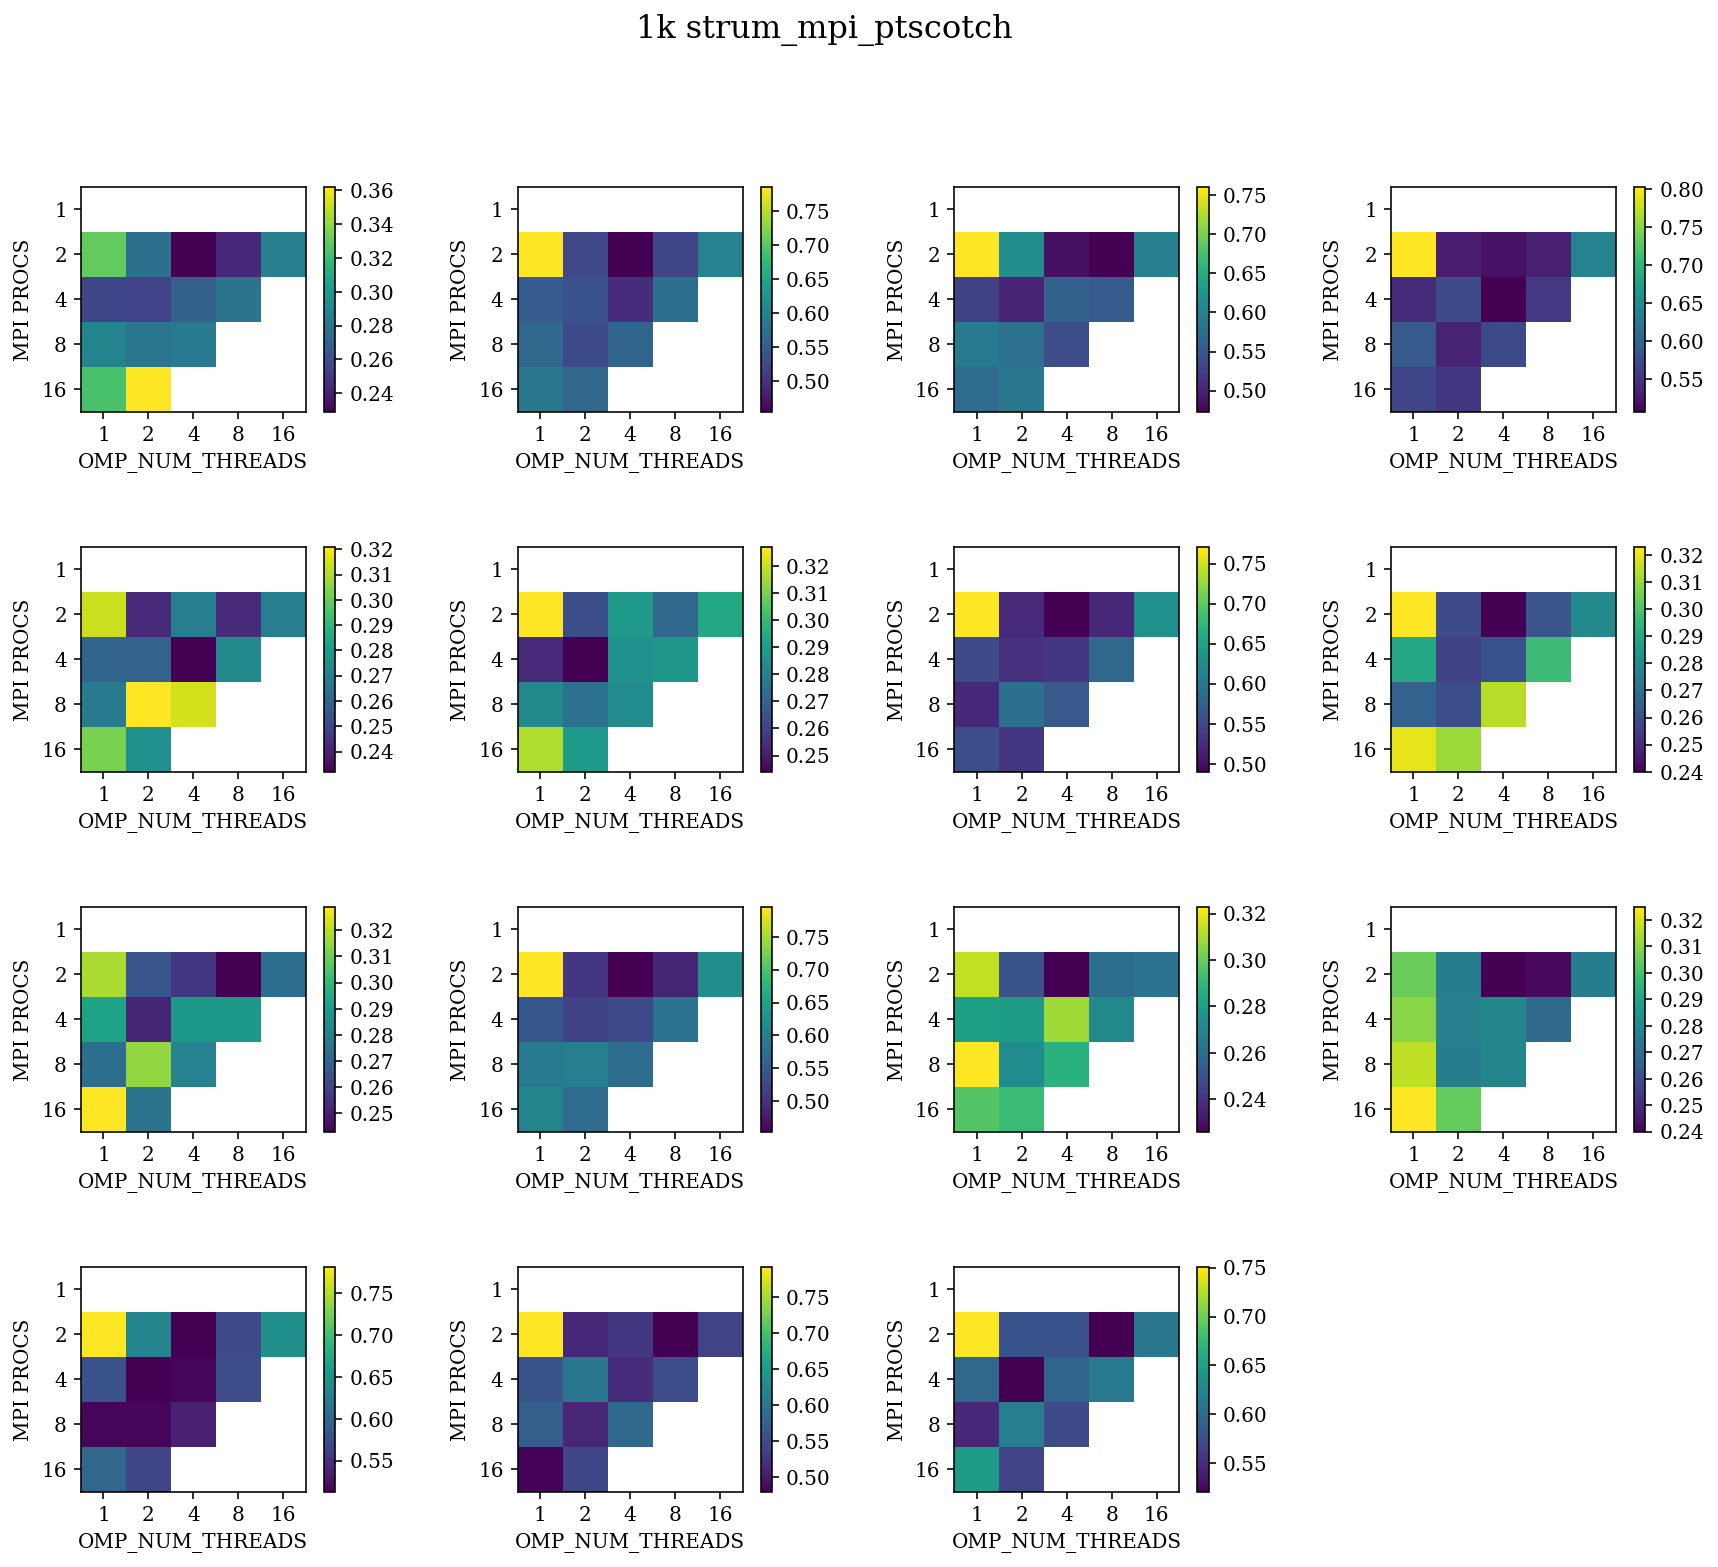

In [14]:
# define the figure size and grid layout properties
figsize = (15, 12)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.6)
fig1 = plt.figure(num=1, figsize=figsize)

fig1.suptitle('1k strum_mpi_ptscotch', size=16)

ax = []
for i, u in enumerate(uniq_ref):
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    cset = ax[-1].imshow(u_dat[u].strum_mpi_ptscotch)
    ax[-1].set_xlabel('OMP_NUM_THREADS')
    ax[-1].set_ylabel('MPI PROCS')
    plt.colorbar(cset)
    ax[-1].set_xticks([l for l in xrange(0,5)])
    ax[-1].set_xticklabels([str(2**l) for l in xrange(0,5)])
    ax[-1].set_yticks([l for l in xrange(0,5)])
    ax[-1].set_yticklabels([str(2**l) for l in xrange(0,5)])

# STRUMPACK OpenMP

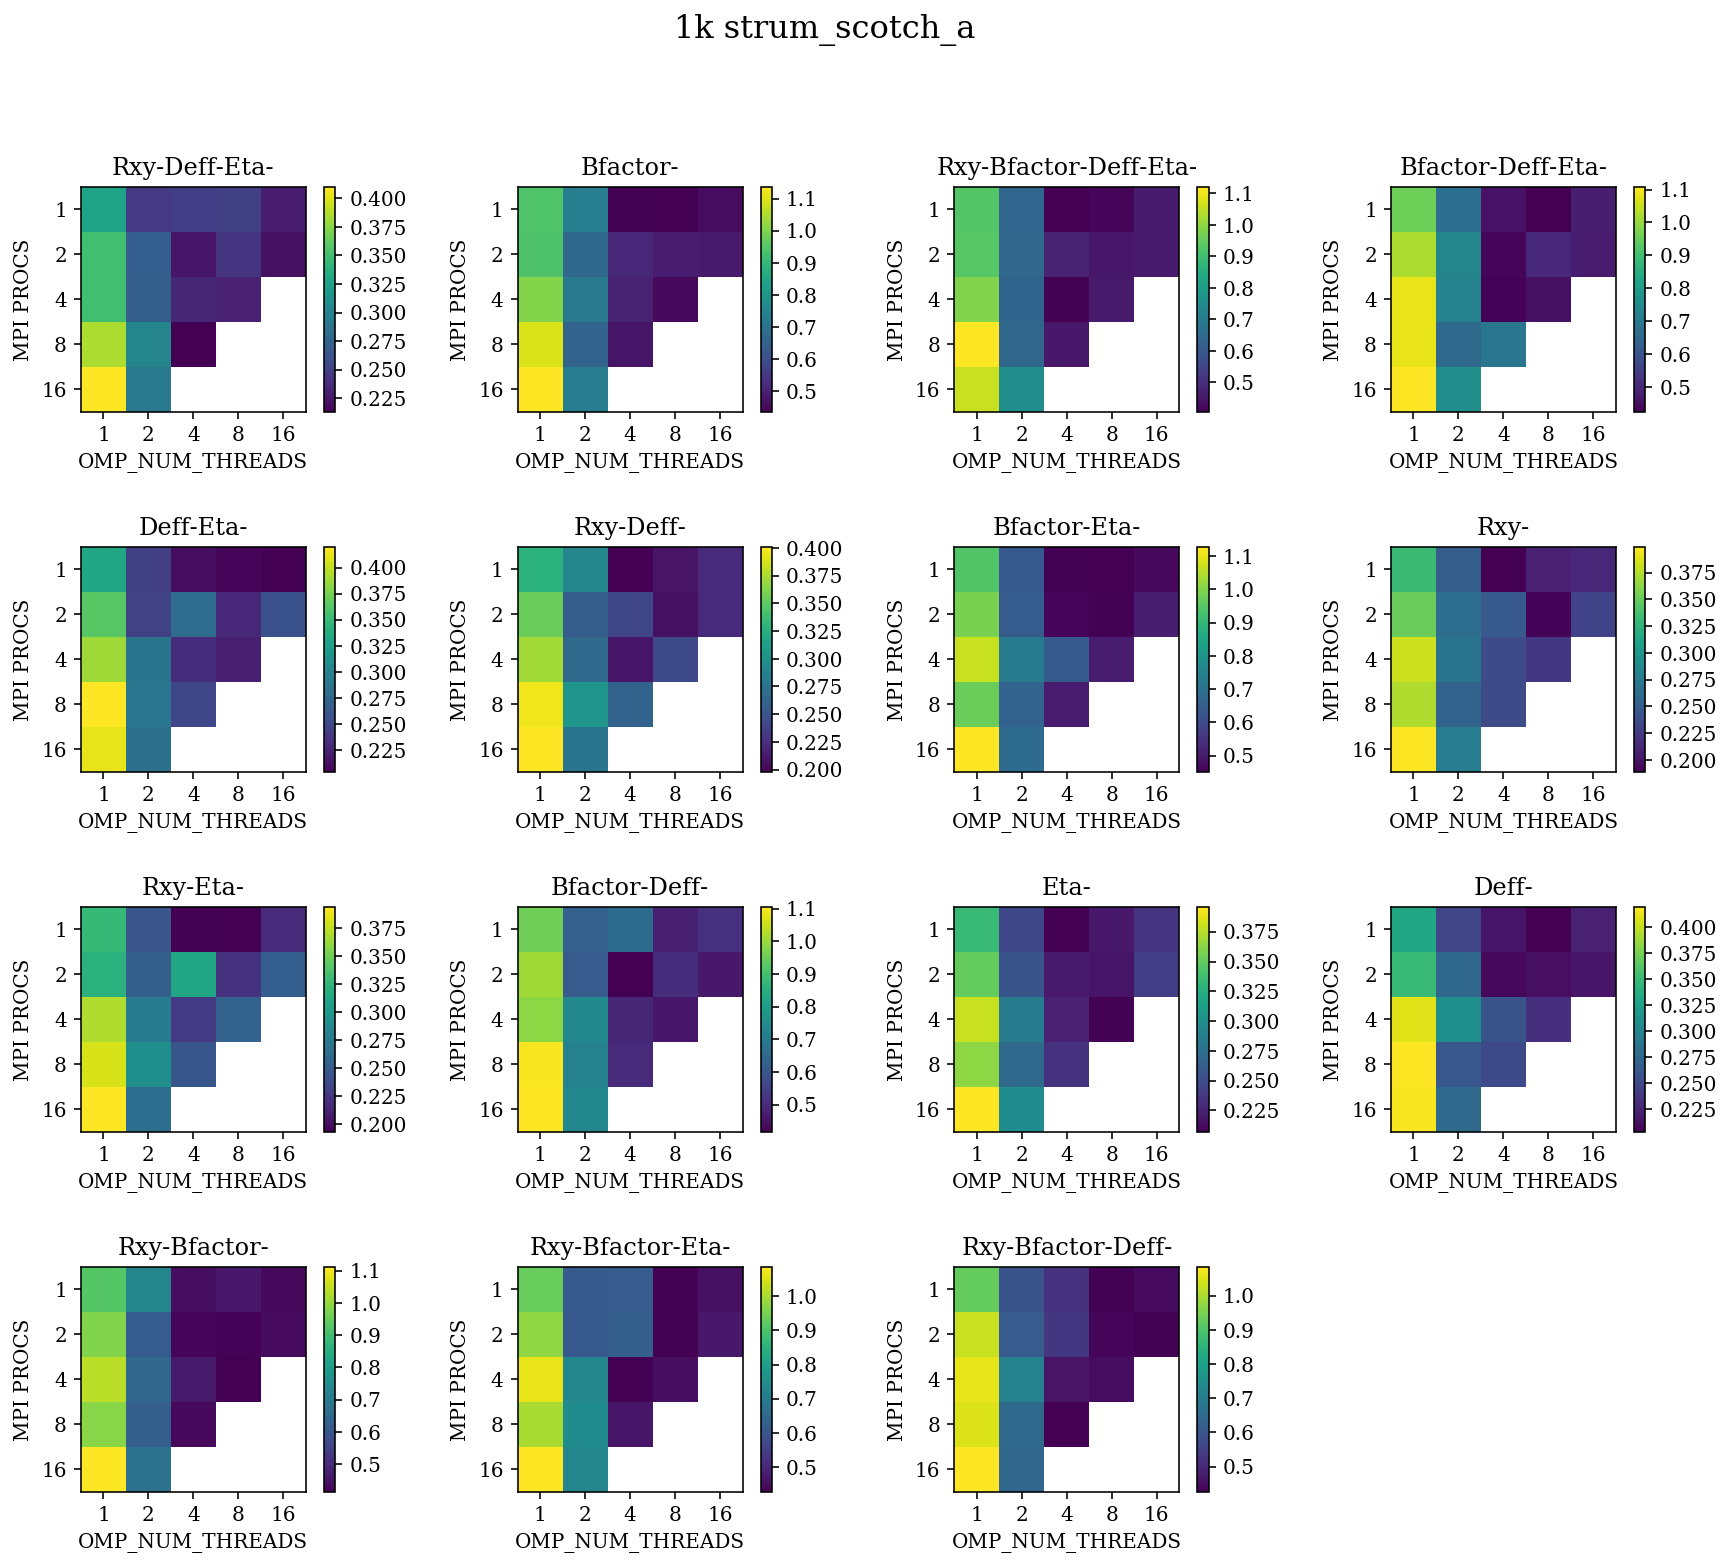

In [10]:
# define the figure size and grid layout properties
figsize = (15, 12)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.6)
fig1 = plt.figure(num=1, figsize=figsize)

fig1.suptitle('1k strum_scotch_a', size=16)
ax = []
cbars= []
for i, u in enumerate(uniq_ref):
    data = u_dat[u].strum_scotch_a
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    cset = ax[-1].imshow(data)
    ax[-1].set_title(u)
    ax[-1].set_xlabel('OMP_NUM_THREADS')
    ax[-1].set_ylabel('MPI PROCS')
    plt.colorbar(cset)
    ax[-1].set_xticks([l for l in xrange(0,5)])
    ax[-1].set_xticklabels([str(2**l) for l in xrange(0,5)])
    ax[-1].set_yticks([l for l in xrange(0,5)])
    ax[-1].set_yticklabels([str(2**l) for l in xrange(0,5)])
plt.show()

# EIGEN LDLT

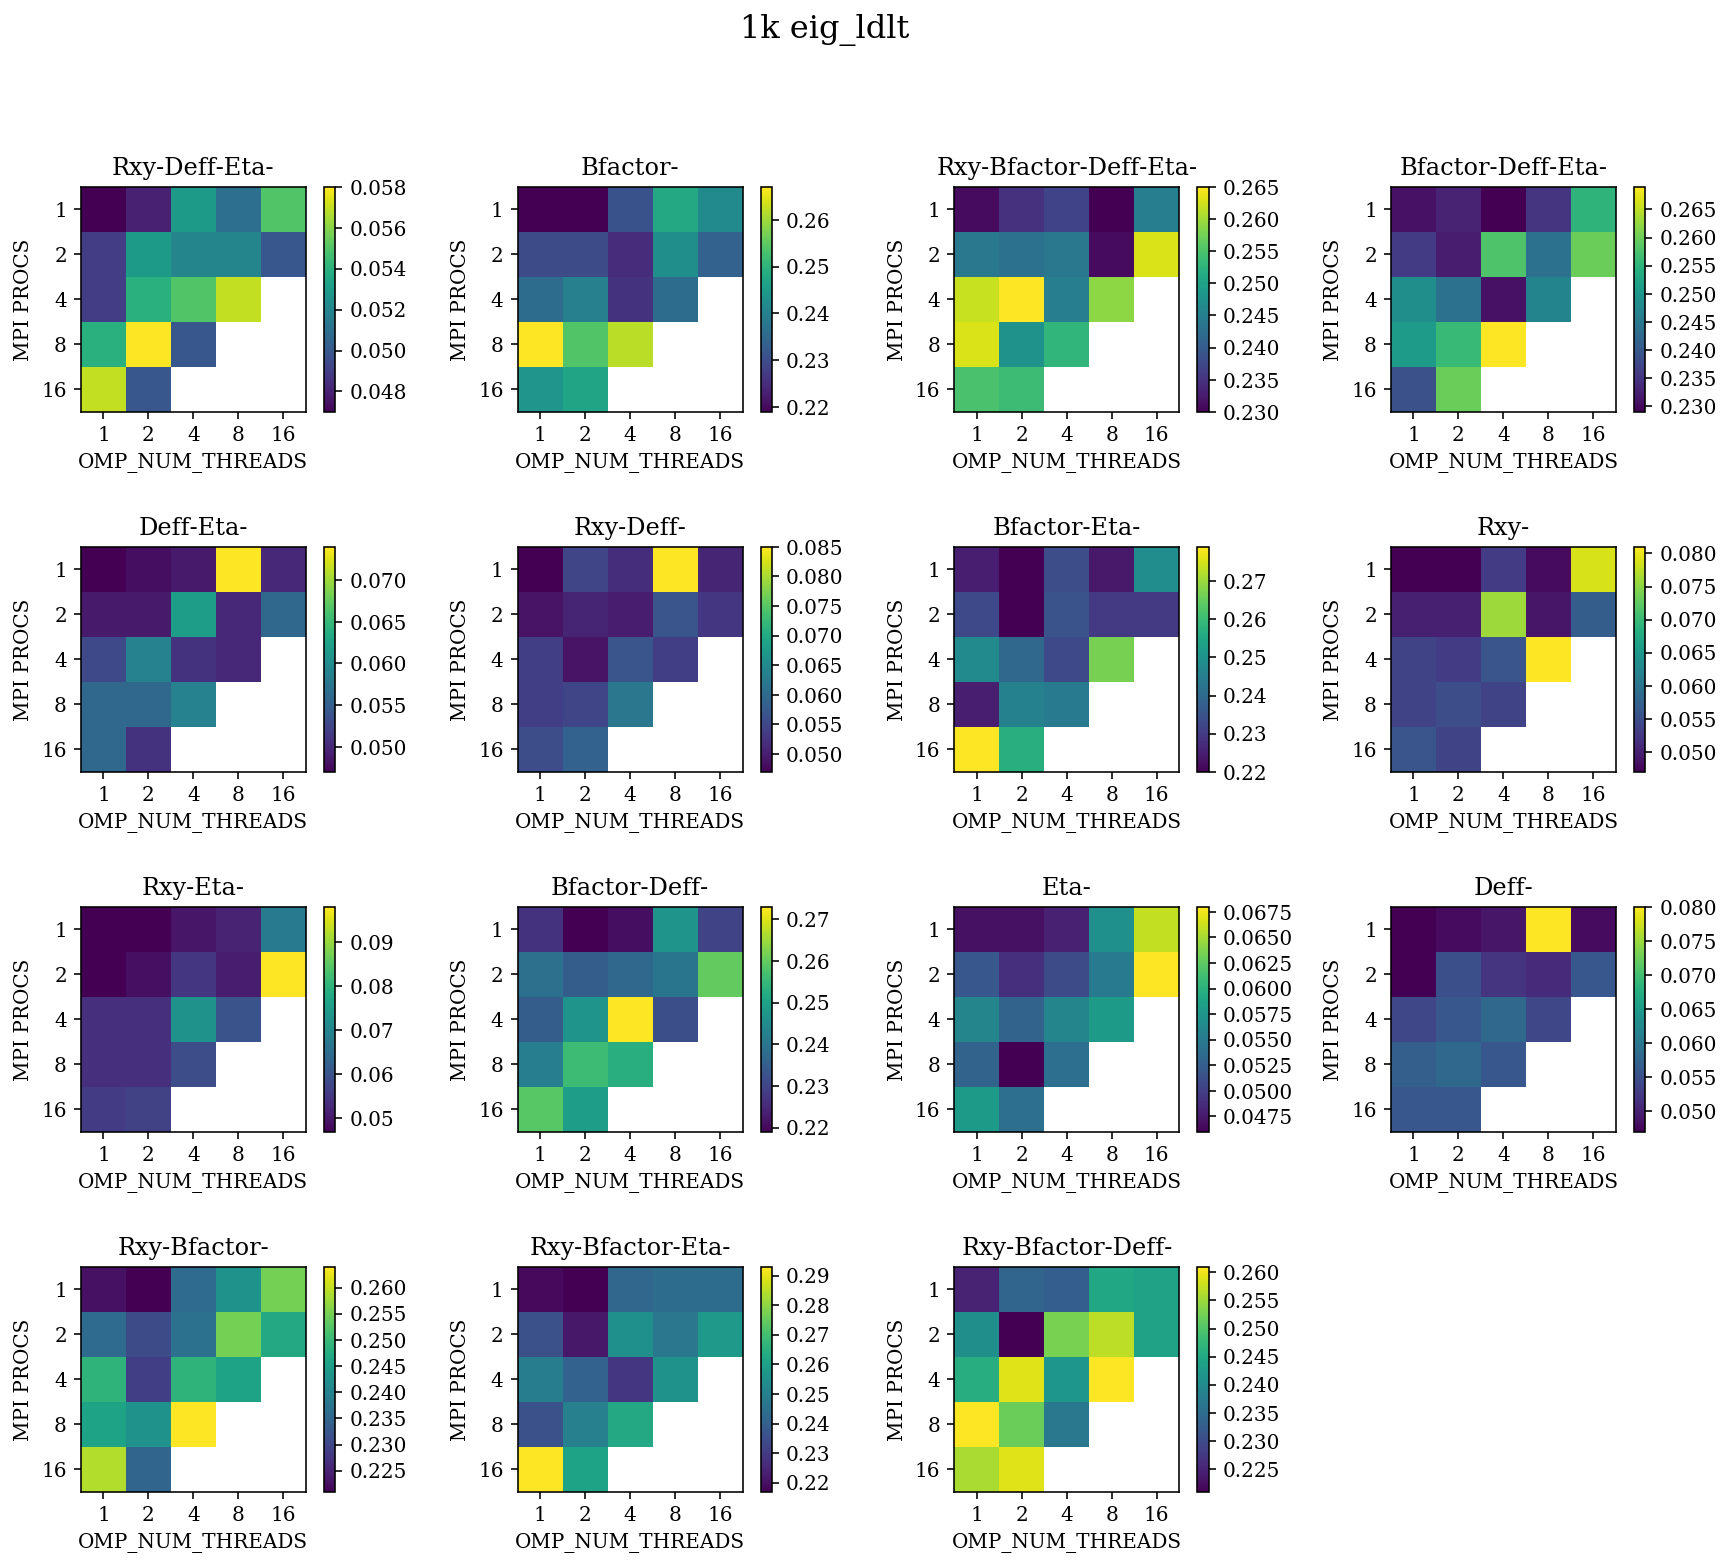

In [11]:
# define the figure size and grid layout properties
figsize = (15, 12)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.6)
fig1 = plt.figure(num=1, figsize=figsize)

fig1.suptitle('1k eig_ldlt', size=16)
ax = []
cbars= []
for i, u in enumerate(uniq_ref):
    data = u_dat[u].eig_ldlt
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    cset = ax[-1].imshow(data)
    ax[-1].set_title(u)
    ax[-1].set_xlabel('OMP_NUM_THREADS')
    ax[-1].set_ylabel('MPI PROCS')
    plt.colorbar(cset)
    ax[-1].set_xticks([l for l in xrange(0,5)])
    ax[-1].set_xticklabels([str(2**l) for l in xrange(0,5)])
    ax[-1].set_yticks([l for l in xrange(0,5)])
    ax[-1].set_yticklabels([str(2**l) for l in xrange(0,5)])

# EIGEN BICGSTAB

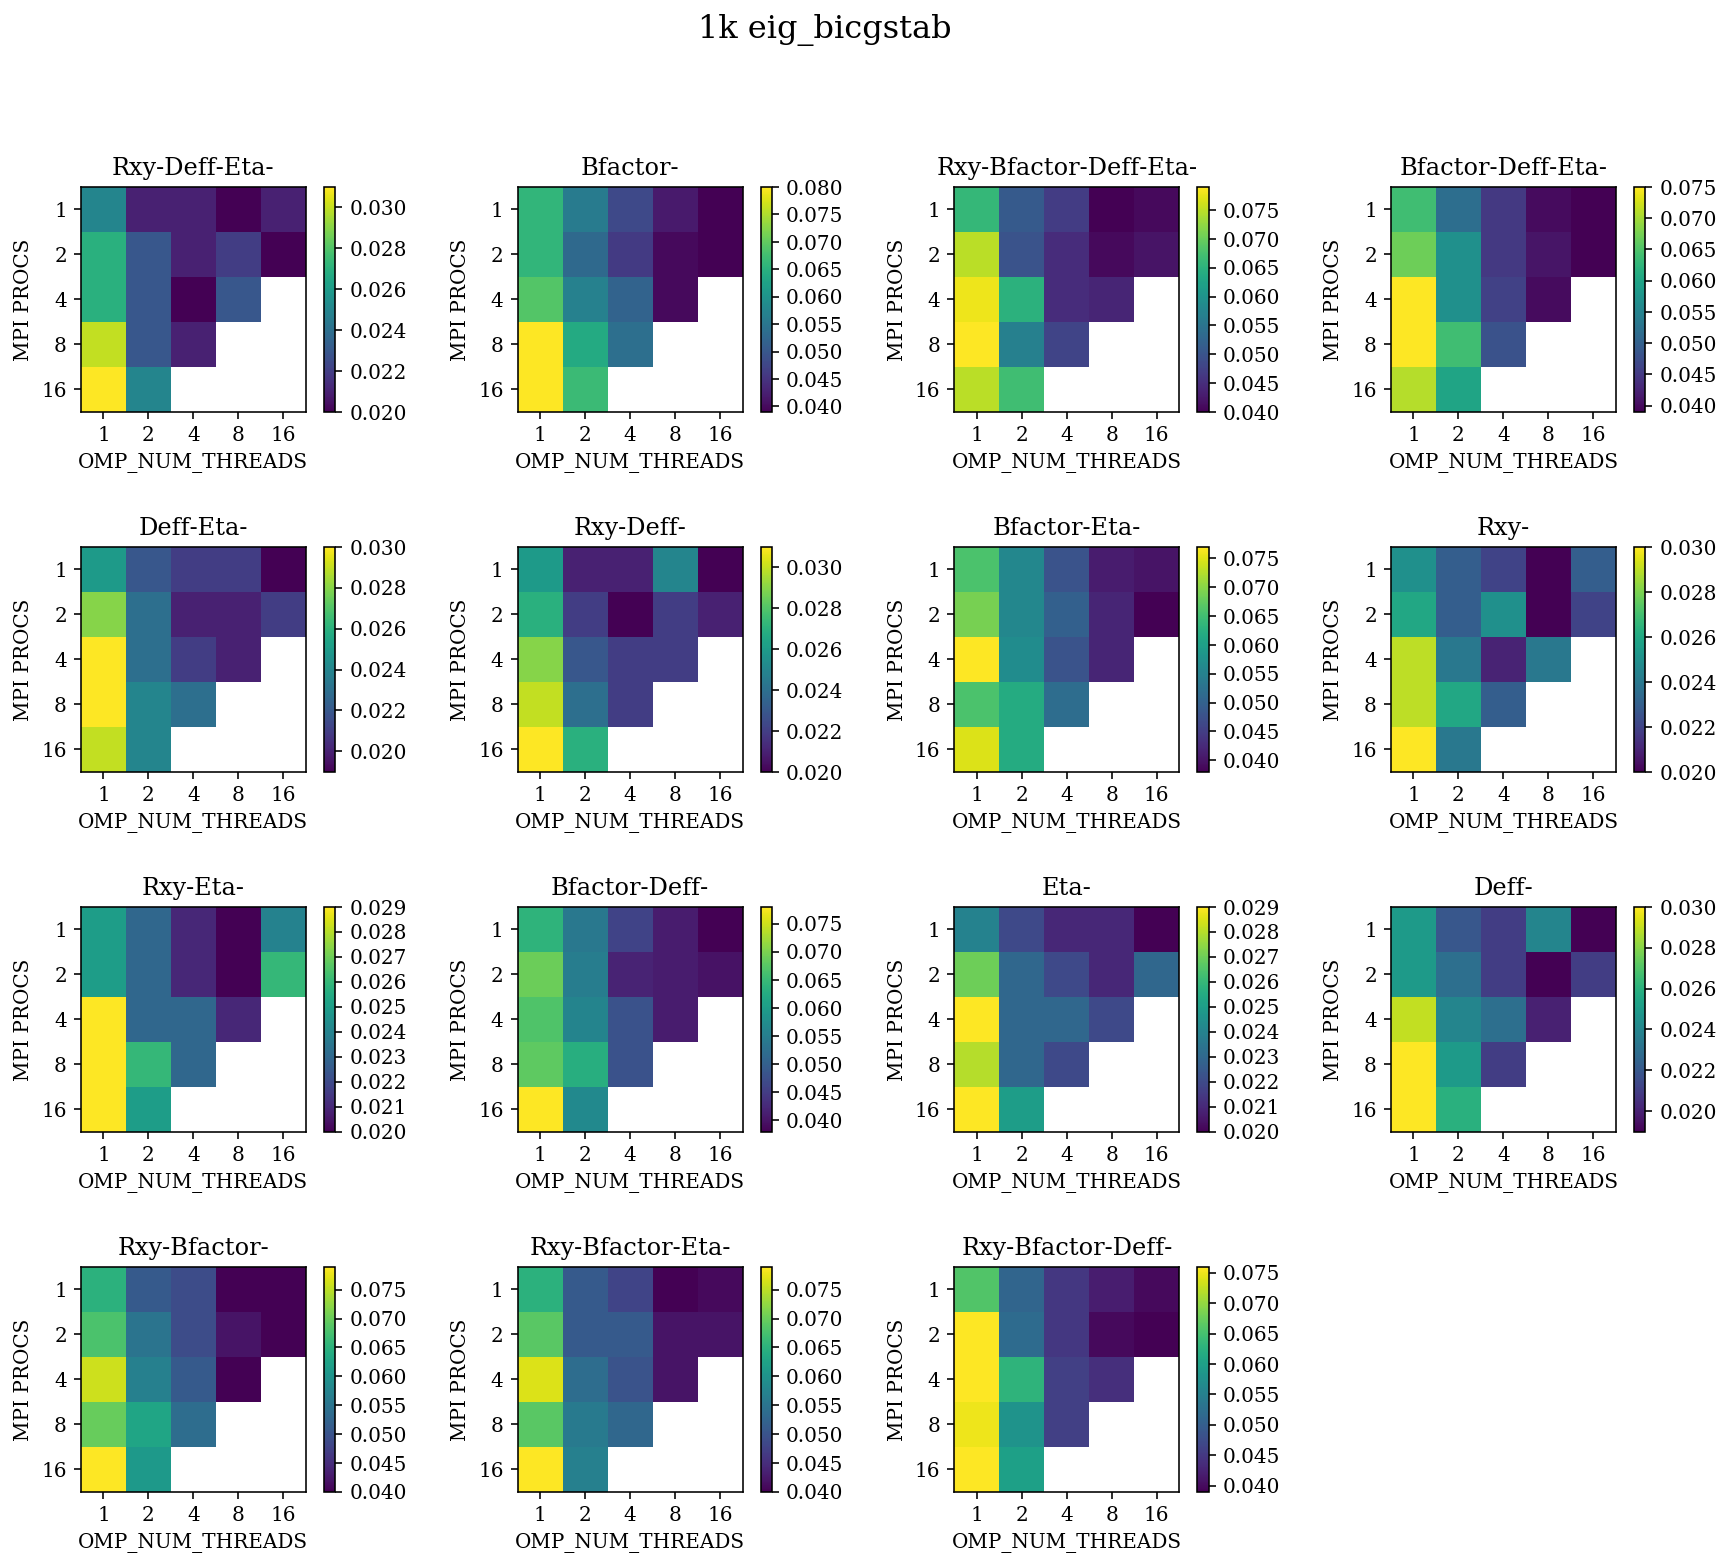

In [12]:
# define the figure size and grid layout properties
figsize = (15, 12)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.6)
fig1 = plt.figure(num=1, figsize=figsize)

fig1.suptitle('1k eig_bicgstab', size=16)
ax = []
cbars= []
for i, u in enumerate(uniq_ref):
    data = u_dat[u].eig_bicgstab
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    cset = ax[-1].imshow(data)
    ax[-1].set_title(u)
    ax[-1].set_xlabel('OMP_NUM_THREADS')
    ax[-1].set_ylabel('MPI PROCS')
    plt.colorbar(cset)
    ax[-1].set_xticks([l for l in xrange(0,5)])
    ax[-1].set_xticklabels([str(2**l) for l in xrange(0,5)])
    ax[-1].set_yticks([l for l in xrange(0,5)])
    ax[-1].set_yticklabels([str(2**l) for l in xrange(0,5)])

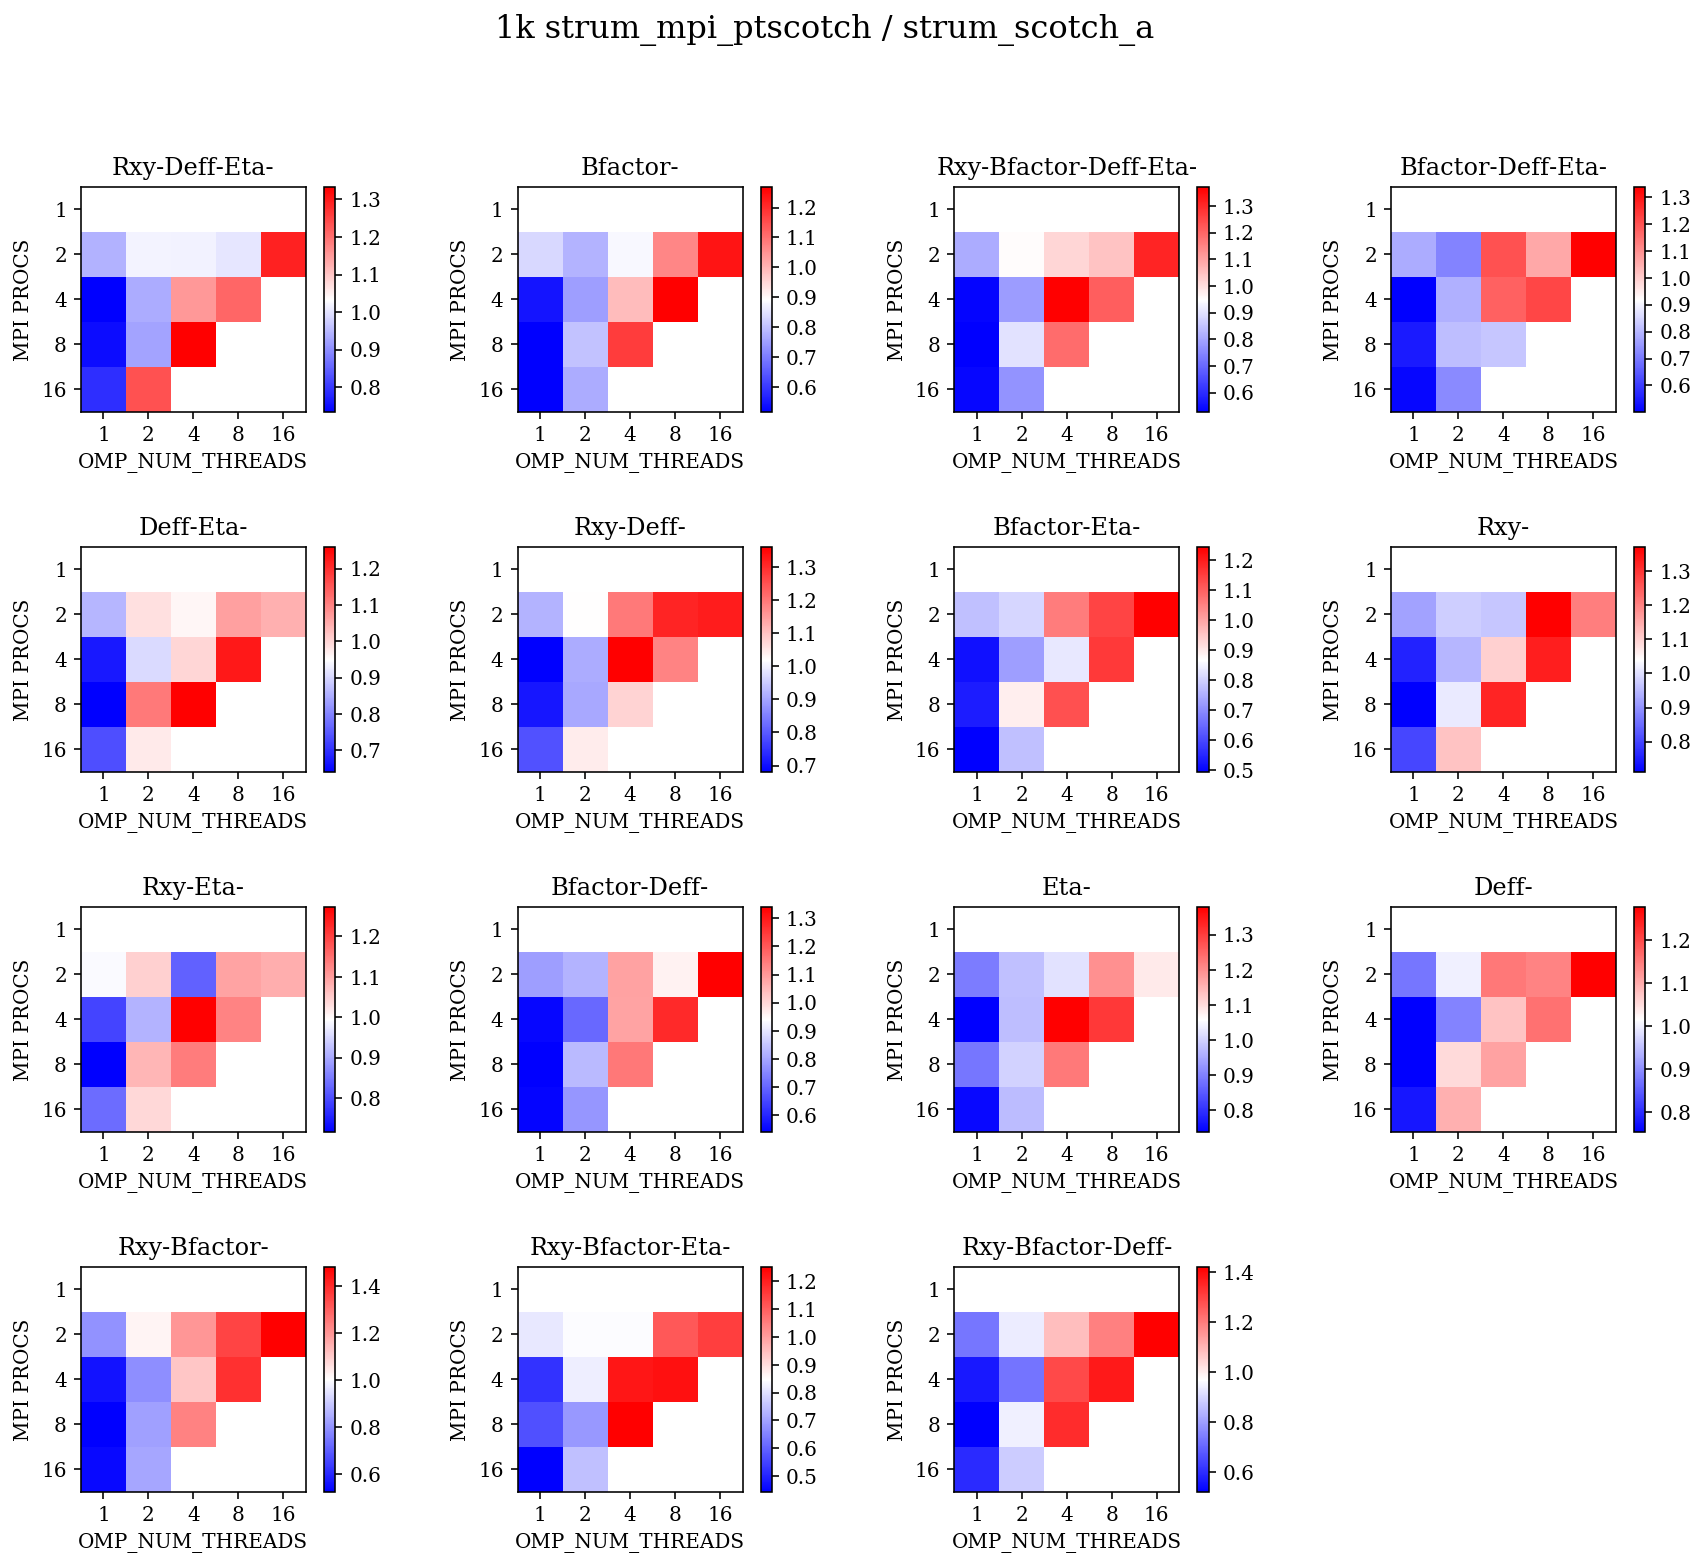

In [13]:
# define the figure size and grid layout properties
figsize = (15, 12)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.6)
fig1 = plt.figure(num=1, figsize=figsize)

fig1.suptitle('1k strum_mpi_ptscotch / strum_scotch_a', size=16)
ax = []
cbars= []
for i, u in enumerate(uniq_ref):
    data = np.divide(u_dat[u].strum_mpi_ptscotch , u_dat[u].strum_scotch_a)
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    cset = ax[-1].imshow(data,cmap='bwr')
    ax[-1].set_title(u)
    ax[-1].set_xlabel('OMP_NUM_THREADS')
    ax[-1].set_ylabel('MPI PROCS')
    plt.colorbar(cset)
    ax[-1].set_xticks([l for l in xrange(0,5)])
    ax[-1].set_xticklabels([str(2**l) for l in xrange(0,5)])
    ax[-1].set_yticks([l for l in xrange(0,5)])
    ax[-1].set_yticklabels([str(2**l) for l in xrange(0,5)])